In [1]:
#載入所需函示庫

#載入所需函示庫
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 60
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import statsmodels
import statistics
import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
def Durbin_Watson_test(x):
    x_square_sum = np.vdot(x, x)
    print("x_square_sum = ", x_square_sum)
    size = x.size
    print("size = ", size)
    x_d = np.zeros((size))
    print("x_d = ", x_d)
    l_size = size - 1
    for i in range(l_size):
        x_d[i + 1] = x[i + 1] - x[i]
    print("x_d = ", x_d)
    d = np.vdot(x_d, x_d) / x_square_sum
    print("d = ", d)
    return(d)

In [3]:
def runsTest(l, l_median): 
    runs, n1, n2 = 1, 0, 0
    if(l[0]) >= l_median:
        n1 += 1   
    else:
        n2 += 1   
    for i in range(1, len(l)): 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
        if(l[i]) >= l_median: 
            n1 += 1   
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    print('runs_exp = ', runs_exp)
    print('stan_dev = ', stan_dev)
    print('z = ', z)
    print('pval_z = ', pval_z)
    return pval_z

In [4]:
def SI_MA(y_v, n):
    y_v_MA_a = np.zeros(len(y_v))
    y_v_MA_a[:] = np.nan
    mvlen = n
    if n % 2 == 0:
        halfwin = int(mvlen / 2)
        y_v_MA_ta = np.zeros(len(y_v))
        for i in range(halfwin, len(y_v) - halfwin + 1):
            y_v_MA_ta[i] = np.mean(y_v[(i-halfwin): (i+halfwin)])
        for ii in range(halfwin, len(y_v) - halfwin):
            y_v_MA_a[ii] = np.mean(y_v_MA_ta[(ii): (ii+2)])
    else:
        halfwin = int((mvlen - 1) / 2)
        for i in range(halfwin, len(y_v) - halfwin):
            y_v_MA_a[i] = np.mean(y_v[(i-halfwin): (i+halfwin+1)])
    SI_MA_a = np.zeros(len(y_v))
    SI_MA_a[:] = np.nan
    SI_MA_a = y_v / y_v_MA_a    
    SI_id_s = np.arange(1,len(y_v)+1)
    SI_id = SI_id_s - np.floor(SI_id_s / n) * n
    SI_id[np.where((SI_id[:] == 0))] = n
    SI_MA_a_df = pd.DataFrame({'SIMA': SI_MA_a, 'SIid': SI_id})
    SI_MA_u = np.zeros(n)
    for j in range(1,n+1):
        SI_MA_u[j-1] = SI_MA_a_df['SIMA'][SI_MA_a_df['SIid'] == j].dropna().mean()  
    SI_MA = SI_MA_u / sum(SI_MA_u) * n
    print('Seasonal Index:', SI_MA)  
    y_v_SI_MA = np.zeros(len(y_v))
    DSI_y_v = np.zeros(len(y_v))
    for k in range(0,len(y_v)):
        Idd = int(SI_MA_a_df['SIid'][k] - 1)
        y_v_SI_MA[k] = SI_MA[Idd]
        DSI_y_v[k] = y_v[k] / SI_MA[Idd]
    print('Deseasonalized Data:', DSI_y_v)
    SI_MA_result_a = np.array([SI_MA_a_df['SIid'], y_v_SI_MA, y_v, DSI_y_v])
    SI_MA_result_df = pd.DataFrame(SI_MA_result_a.T, columns = ['SID', 'SeaIdx', 'orig', 'Des_D'])
    return {"ma_ind":SI_MA, "SI_MA_res":SI_MA_result_df}

In [5]:
def SI_LR(y_v, n):
    y_data = y_v
    X_data_ar = np.arange(1, len(y_v)+1)
    X_data_T = X_data_ar.T
    X_data = pd.DataFrame(X_data_T,columns = ['Time'])
    X_data = sm.add_constant(X_data)
    olsmod = sm.OLS(y_data, X_data)
    result_reg = olsmod.fit()
    st, data, ss2 = sso.summary_table(result_reg, alpha=0.05)
    y_v_LR_a = data[:, 2]
    SI_LR_a = y_v / y_v_LR_a
    SI_id_s = np.arange(1,len(y_v)+1)
    SI_id = SI_id_s - np.floor(SI_id_s / n) * n
    SI_id[np.where((SI_id[:] == 0))] = n
    SI_LR_a_df = pd.DataFrame({'SILR': SI_LR_a, 'SIid': SI_id})
    SI_LR_u = np.zeros(n)
    for j in range(1,n+1):
        SI_LR_u[j-1] = SI_LR_a_df['SILR'][SI_LR_a_df['SIid'] == j].dropna().mean()
    SI_LR = SI_LR_u / sum(SI_LR_u) * n
    print('Seasonal Index:', SI_LR)
    print('\n')
    y_v_SI_LR = np.zeros(len(y_v))
    DSI_y_v = np.zeros(len(y_v))
    for k in range(0,len(y_v)):
        Idd = int(SI_LR_a_df['SIid'][k] - 1)
        y_v_SI_LR[k] = SI_LR[Idd]
        DSI_y_v[k] = y_v[k] / SI_LR[Idd]
    print('Deseasonalized Data:', DSI_y_v)
    SI_LR_result_a = np.array([SI_LR_a_df['SIid'], y_v_SI_LR, y_v, DSI_y_v])
    SI_LR_result_df = pd.DataFrame(SI_LR_result_a.T, columns = ['SID', 'SeaIdx', 'orig', 'Des_D'])
    return {"LR_ind":SI_LR, "SI_LR_res":SI_LR_result_df}

In [6]:
def ErrMetrix(y_v, f_v):
    y_v_n = pd.DataFrame({'orig': y_v})
    f_v_n = pd.DataFrame({'forecast': f_v})
    err1 = (y_v_n['orig'] - f_v_n['forecast']).dropna().values
    err1p = ((y_v_n['orig'] - f_v_n['forecast'])/ y_v_n['orig']).dropna().values
    MAD = round(np.absolute(err1).mean(),6)
    MSE = round(np.mean(err1 * err1),6)
    RMSE = round(np.sqrt(np.mean(err1 * err1)),6)
    MAPE = round(np.absolute(err1p).mean() * 100, 6)
    print("MAD = ", MAD)
    print("MSE = ", MSE)
    print("RMSE = ", RMSE)
    print("MAPE = ", MAPE, "%")
    return MAD, MSE, RMSE, MAPE

In [7]:
df = pd.read_excel('Time_Series_Traffic_V.xlsx')
print('Head of dataset:')
display(df.head())
print("Tail of dataset:")
display(df.tail())

Head of dataset:


,Year,Month,Billions_of_miles
0,2003,1,223
1,2003,2,214
2,2003,3,251
3,2003,4,251
4,2003,5,256


Tail of dataset:


,Year,Month,Billions_of_miles
31,2005,8,265
32,2005,9,245
33,2005,10,257
34,2005,11,245
35,2005,12,245


In [8]:
#調整期數從0開始
df["t"] = list(range(0,len(df)))
print('Head of dataset:')
display(df.head())
print("Tail of dataset:")
display(df.tail())

Head of dataset:


,Year,Month,Billions_of_miles,t
0,2003,1,223,0
1,2003,2,214,1
2,2003,3,251,2
3,2003,4,251,3
4,2003,5,256,4


Tail of dataset:


,Year,Month,Billions_of_miles,t
31,2005,8,265,31
32,2005,9,245,32
33,2005,10,257,33
34,2005,11,245,34
35,2005,12,245,35


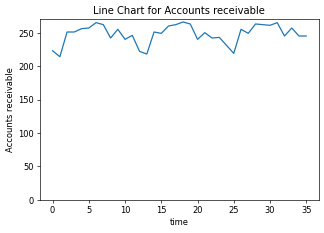

In [10]:
#確認season內的期數與data相符
plt.plot(df['t'], df['Billions_of_miles'])
plt.ylim(0, max(df['Billions_of_miles'])+5)
plt.xlabel('time')
plt.ylabel('Accounts receivable')
plt.title('Line Chart for Accounts receivable')
plt.show()

According to the plot above, we can check that there are 4 periods in one season.

# CMV

Seasonal Index: [0.91235306 0.8802234  1.01868366 1.00217758 1.05185252 1.05354091
 1.07325905 1.0599714  0.9724309  1.01868221 0.97184137 0.98498395]
Deseasonalized Data: [244.42292242 243.12009993 246.39641386 250.45461499 243.38012634
 243.93926918 246.91149784 247.1764801  248.86087037 250.32340609
 246.95388394 249.7502624  243.3268555  247.66440087 246.39641386
 248.45896068 247.18294081 248.68516936 247.84323935 248.11990178
 246.80416896 245.41510401 249.01183297 246.70452749 253.19145775
 248.8004761  250.32304994 248.45896068 250.03505167 248.68516936
 243.18453184 250.00674514 251.94592248 252.28672693 252.09875652
 248.73501743]
                            OLS Regression Results                            
Dep. Variable:                  Des_D   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     13.08
Date:                Tue, 15 Jun 20

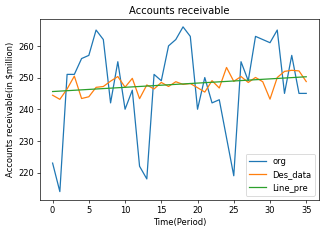

In [11]:
#Seasonal index 與 deseasonalizing
df_SIMA = pd.DataFrame(columns=["ma_ind", "SI_MA_res"])
df_SIMA = SI_MA(df['Billions_of_miles'], 12)

#SI
df_MA_Idx = df_SIMA["ma_ind"]
#各期Quarter, SI, ori, des
df_MA_Result = df_SIMA["SI_MA_res"]

#利用Des和Period(t)跑regression
y_data_df_MA = df_MA_Result['Des_D']
X_data_ar_df = np.array(df['t'])
X_data_ar_df_T = X_data_ar_df.T
X_data_df = pd.DataFrame(X_data_ar_df_T, columns = ['t'])
X_data_df = sm.add_constant(X_data_df)
olsmod_df_MA = sm.OLS(y_data_df_MA, X_data_df)
result_reg_df_MA = olsmod_df_MA.fit()
print(result_reg_df_MA.summary())

#linear regression之於各期的結果（desensonalized）
df_MA_st_2, df_MA_data_2, df_MA_ss2_2 = sso.summary_table(result_reg_df_MA, alpha=0.05)
df_MA_y_pre_2 = df_MA_data_2[:, 2]
des_pre_df_MA = df_MA_y_pre_2
#print(des_pre_df4_MA)

plt.plot(df['t'], df_MA_Result['orig'])
plt.plot(df['t'], df_MA_Result['Des_D'])
plt.plot(df['t'], des_pre_df_MA)
plt.legend(labels=['org', 'Des_data', 'Line_pre'])
plt.xlabel('Time(Period)')
plt.ylabel('Accounts receivable(in $million)')
plt.title('Accounts receivable')
plt.show()

### Requirements check. 

In [12]:
data = df_MA_data_2
y_pre = data[:, 2]
SD = data[:, 10]

#### Normality
H0 : Normal distributed  
H1 : Not normal distributed 

In [13]:
stat, p = stats.shapiro(SD)
print('Shapiro Test: Statistics=%f, p=%f' % (stat, p))

Shapiro Test: Statistics=0.977908, p=0.674404


Since p-value > alpha = 0.05, we can not reject H0 at significance level at alpha = 0.05.  
There is no evidence to show that it is not normally distributed.  
#### Homoscedasticity
H0 : Homoscedasticity  
H1 : Not Homoscedasticity

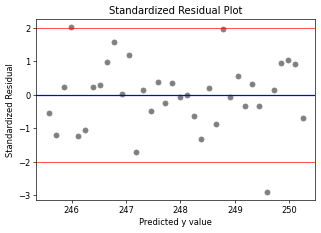

In [14]:
plt.plot(y_pre, SD, 'o', color = 'gray')
plt.axhline(y=2, color = 'red', lw = 0.8)
plt.axhline(y=0, color = 'blue')
plt.axhline(y=-2, color = 'red', lw = 0.8)
plt.title('Standardized Residual Plot')
plt.xlabel('Predicted y value')
plt.ylabel('Standardized Residual')
plt.show()

We do not reject H0. We can assume the variation is constant and the mean is around 0.
#### Independence
H0 : Independence  
H1 : Not independence  

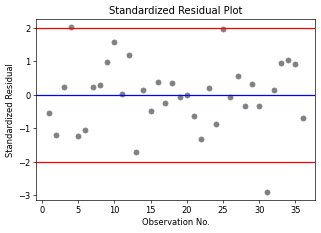

runs =  23
n1 =  18
n2 =  18
runs_exp =  19.0
stan_dev =  2.9568322818274866
z =  1.3527990831890464
pval_z =  0.17611982574413676
p_value for Z-statistic=  0.17611982574413676


In [15]:
Id = data[:, 0]
plt.plot(Id, SD, 'o', color = 'gray')
plt.axhline(y=0, color = 'blue')
plt.axhline(y=2, color = 'red')
plt.axhline(y=-2, color = 'red')
plt.title('Standardized Residual Plot')
plt.xlabel('Observation No.')
plt.ylabel('Standardized Residual')
plt.show()

SD_median = statistics.median(SD)
Z_pval = runsTest(SD, SD_median) 
print('p_value for Z-statistic= ', Z_pval)

Since n1<=20 and n2<=20, we check with run table.  
lower bound = 4 < runs = 7 < upper bound = 14  
Thus, there is no evidence to infer the sample is not random selected.  
#### According to the results above, all requirements are satisfied
#### Autocorreltaion  
H0: The data are not first-order correlated  
H1: The data are first-order correlated  

In [16]:
d = Durbin_Watson_test(SD)
print(d)

x_square_sum =  36.203956526564234
size =  36
x_d =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
x_d =  [ 0.         -0.65615949  1.44078615  1.78384423 -3.27280301  0.19671777
  1.28060147  0.05840242  0.69303103  0.59075066 -1.56293006  1.18349817
 -2.91100928  1.86522505 -0.62035915  0.85368054 -0.62313     0.6050755
 -0.43092578  0.06340666 -0.6408191  -0.67429853  1.53329185 -1.08252652
  2.82222697 -2.01064256  0.61982948 -0.89196546  0.64626552 -0.66619318
 -2.54392384  3.01951961  0.821785    0.09884914 -0.1425373  -1.60761123]
d =  2.0462195176496825
2.0462195176496825


size = 16, k = 2(includes intercept), dL = 0.98013, dU = 1.23538  
Since dU < d= 1.381325671272503 < 4-dU, we can not reject H0.  
Thus, there is not enough evidence to infer that first order auto-correlation exist.  
We dont need to apply Autoregression model.

In [18]:
#predict for the next year
Sea_pre_df_MA = des_pre_df_MA * df_MA_Result['SeaIdx']
New_t_2 = np.arange(36, 48, 1)
Total_t_2 = np.append(df['t'], New_t_2)
New_t_2 = sm.add_constant(New_t_2)
df_MA_des_pre_New_t_2 = result_reg_df_MA.predict(New_t_2)
print('New Des Prediction', df_MA_des_pre_New_t_2)
df_MA_Sea_pre_New_t_2 = df_MA_des_pre_New_t_2 * df_MA_Idx
print('New Seasonal Prediction', df_MA_Sea_pre_New_t_2)
New_Nan = np.zeros(New_t_2.shape[0])
New_Nan[:] = np.nan

New Des Prediction [250.38210682 250.51529093 250.64847504 250.78165915 250.91484326
 251.04802736 251.18121147 251.31439558 251.44757969 251.5807638
 251.71394791 251.84713202]
New Seasonal Prediction [228.4368801  220.50942013 255.33150523 251.32775633 263.925411
 264.48936757 269.5825088  266.38607207 244.51539607 256.28084793
 244.62602707 248.06538292]


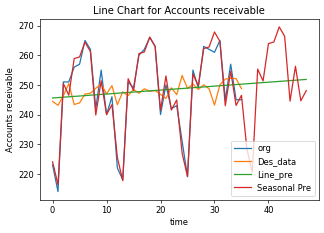

In [19]:
df_MA_New_orig_2 = np.append(df_MA_Result['orig'], New_Nan)
df_MA_New_Des_D_2 = np.append(df_MA_Result['Des_D'], New_Nan)
df_MA_New_des_pre_2 = np.append(des_pre_df_MA, df_MA_des_pre_New_t_2)
df_MA_New_Sea_pre_2 = np.append(Sea_pre_df_MA, df_MA_Sea_pre_New_t_2)
df_MA_S_a = np.array([Total_t_2, df_MA_New_orig_2, df_MA_New_Des_D_2, df_MA_New_des_pre_2, df_MA_New_Sea_pre_2])
df_MA_S_df = pd.DataFrame(df_MA_S_a.T, columns=['time', 'org', 'Des_data', 'Line_pre', 'Seasonal Pre'])
#display(df_MA_S_df)

plt.plot(Total_t_2, df_MA_New_orig_2)
plt.plot(Total_t_2, df_MA_New_Des_D_2)
plt.plot(Total_t_2, df_MA_New_des_pre_2)
plt.plot(Total_t_2, df_MA_New_Sea_pre_2)
plt.legend(labels=['org', 'Des_data', 'Line_pre', 'Seasonal Pre'])
plt.xlabel('time')
plt.ylabel('Accounts receivable')
plt.title('Line Chart for Accounts receivable')
plt.show()

# SLR

Seasonal Index: [0.91443713 0.87968778 1.02182126 1.01000768 1.04913471 1.05069963
 1.06448165 1.06049671 0.97484484 1.02067129 0.97266246 0.98105487]


Deseasonalized Data: [243.86586446 243.26812755 245.6398284  248.51296284 244.01060972
 244.59892579 248.9474583  247.0540423  248.24463358 249.83557591
 246.74541287 250.75050181 242.77229556 247.81519536 245.6398284
 246.53277987 247.82327549 249.35765976 249.88688267 247.99699666
 246.19302504 244.93683913 248.80162464 247.69256886 252.61441565
 248.95196231 249.55440734 246.53277987 250.68277483 249.35765976
 245.18976082 249.88290538 251.32204639 251.79507062 251.8859423
 249.73119083]
                            OLS Regression Results                            
Dep. Variable:                  Des_D   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     17.15
Date:                Tue, 15 Jun 20

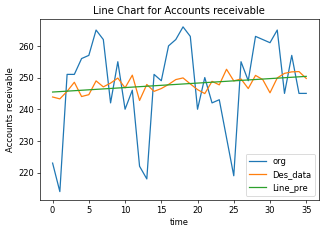

In [20]:
df_SILR = pd.DataFrame(columns=["LR_ind", "SI_LR_res"])
df_SILR = SI_LR(df['Billions_of_miles'], 12)
df_LR_Idx = df_SILR["LR_ind"]
df_LR_Result = df_SILR["SI_LR_res"]
y_data_df_LR = df_LR_Result['Des_D']
X_data_ar_df = np.array(df['t'])
X_data_ar_df_T = X_data_ar_df.T
X_data_df = pd.DataFrame(X_data_ar_df_T, columns = ['t'])
X_data_df = sm.add_constant(X_data_df)
olsmod_df_LR = sm.OLS(y_data_df_LR, X_data_df)
result_reg_df_LR = olsmod_df_LR.fit()
print(result_reg_df_LR.summary())
df_LR_st_2, df_LR_st_data_2, df_LR_st_ss2_2 = sso.summary_table(result_reg_df_LR, alpha=0.05)
df_LR_st_y_pre_2 = df_LR_st_data_2[:, 2]
df_LR_st_SD_2 = df_LR_st_data_2[:, 10]
des_pre_df_LR = df_LR_st_y_pre_2
print(des_pre_df_LR)
plt.plot(df['t'], df_LR_Result['orig'])
plt.plot(df['t'], df_LR_Result['Des_D'])
plt.plot(df['t'], des_pre_df_LR)
plt.legend(labels=['org', 'Des_data', 'Line_pre'])
plt.xlabel('time')
plt.ylabel('Accounts receivable')
plt.title('Line Chart for Accounts receivable')
plt.show()

### Requirements check. 

In [21]:
data = df_LR_st_data_2
y_pre = data[:, 2]
SD = data[:, 10]

#### Normality
H0 : Normal distributed  
H1 : Not normal distributed 

In [22]:
stat, p = stats.shapiro(SD)
print('Shapiro Test: Statistics=%f, p=%f' % (stat, p))

Shapiro Test: Statistics=0.979473, p=0.727632


Since p-value > alpha = 0.05, we can not reject H0 at significance level at alpha = 0.05.  
There is no evidence to show that it is not normally distributed.  
#### Homoscedasticity
H0 : Homoscedasticity  
H1 : Not Homoscedasticity

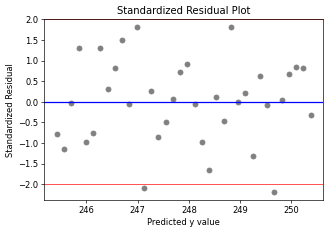

In [23]:
plt.plot(y_pre, SD, 'o', color = 'gray')
plt.axhline(y=2, color = 'red', lw = 0.8)
plt.axhline(y=0, color = 'blue')
plt.axhline(y=-2, color = 'red', lw = 0.8)
plt.title('Standardized Residual Plot')
plt.xlabel('Predicted y value')
plt.ylabel('Standardized Residual')
plt.show()

We do not reject H0. We can assume the variation is constant and the mean is around 0.
#### Independence
H0 : Independence  
H1 : Not independence  

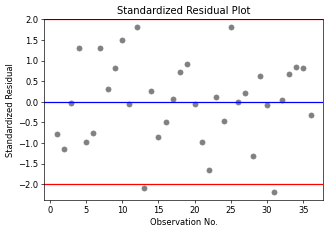

runs =  21
n1 =  18
n2 =  18
runs_exp =  19.0
stan_dev =  2.9568322818274866
z =  0.6763995415945232
pval_z =  0.4987870082234577
p_value for Z-statistic=  0.4987870082234577


In [24]:
Id = data[:, 0]
plt.plot(Id, SD, 'o', color = 'gray')
plt.axhline(y=0, color = 'blue')
plt.axhline(y=2, color = 'red')
plt.axhline(y=-2, color = 'red')
plt.title('Standardized Residual Plot')
plt.xlabel('Observation No.')
plt.ylabel('Standardized Residual')
plt.show()

SD_median = statistics.median(SD)
Z_pval = runsTest(SD, SD_median) 
print('p_value for Z-statistic= ', Z_pval)

Since n1<=20 and n2<=20, we check with run table.  
lower bound = 4 < runs = 7 < upper bound = 14  
Thus, there is no evidence to infer the sample is not random selected.  
#### According to the results above, all requirements are satisfied  
#### Autocorreltaion  
H0: The data are not first-order correlated  
H1: The data are first-order correlated  

In [25]:
d = Durbin_Watson_test(SD)
print(d)

x_square_sum =  35.8987742206997
size =  36
x_d =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
x_d =  [ 0.         -0.36201648  1.10398912  1.3403432  -2.27439463  0.22111698
  2.04428294 -0.98844408  0.50546459  0.69580932 -1.55546793  1.85249384
 -3.88946384  2.3458542  -1.10656631  0.35928655  0.54826601  0.66412422
  0.18491837 -0.96843572 -0.92822722 -0.66814126  1.77814969 -0.59836387
  2.29117702 -1.82369049  0.22194448 -1.52575682  1.93605717 -0.70981505
 -2.09855333  2.21650406  0.63682799  0.16624983 -0.0211652  -1.13793904]
d =  2.0861793217078417
2.0861793217078417


size = 16, k = 2(includes intercept), dL = 0.98013, dU = 1.23538  
Since dU < d= 1.347975870976776 < 4-dU, we can not reject H0.  
Thus, there is not enough evidence to infer that first order auto-correlation exist.  
We dont need to apply Autoregression model.

New Des Prediction [250.51582081 250.65718074 250.79854068 250.93990062 251.08126055
 251.22262049 251.36398043 251.50534036 251.6467003  251.78806024
 251.92942017 252.07078011]
New Seasonal Prediction [229.08096696 220.50005982 256.2712819  253.45122578 263.41806521
 263.95951355 267.57234345 266.72058696 245.31648719 256.9928447
 245.04228929 247.29526545]


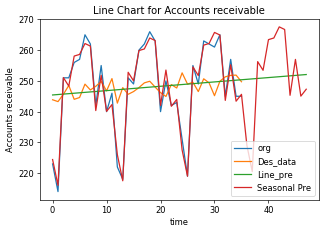

In [27]:
Sea_pre_df_LR = des_pre_df_LR * df_LR_Result['SeaIdx']
New_t_2 = np.arange(36, 48, 1)
Total_t_2 = np.append(df['t'], New_t_2)
New_t_2 = sm.add_constant(New_t_2)
df_LR_st_des_pre_New_t_2 = result_reg_df_LR.predict(New_t_2)
print('New Des Prediction', df_LR_st_des_pre_New_t_2)
df_LR_st_Sea_pre_New_t_2 = df_LR_st_des_pre_New_t_2 * df_LR_Idx
print('New Seasonal Prediction', df_LR_st_Sea_pre_New_t_2)
New_Nan = np.zeros(New_t_2.shape[0])
New_Nan[:] = np.nan

df_LR_st_New_orig_2 = np.append(df_LR_Result['orig'], New_Nan)
df_LR_st_New_Des_D_2 = np.append(df_LR_Result['Des_D'], New_Nan)
df_LR_st_New_des_pre_2 = np.append(des_pre_df_LR, df_LR_st_des_pre_New_t_2)
df_LR_st_New_Sea_pre_2 = np.append(Sea_pre_df_LR, df_LR_st_Sea_pre_New_t_2)
plt.plot(Total_t_2, df_LR_st_New_orig_2)
plt.plot(Total_t_2, df_LR_st_New_Des_D_2)
plt.plot(Total_t_2, df_LR_st_New_des_pre_2)
plt.plot(Total_t_2, df_LR_st_New_Sea_pre_2)
plt.legend(labels=['org', 'Des_data', 'Line_pre', 'Seasonal Pre'])
plt.xlabel('time')
plt.ylabel('Accounts receivable')
plt.title('Line Chart for Accounts receivable')
plt.show()

# Dummy

                            OLS Regression Results                            
Dep. Variable:      Billions_of_miles   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     98.06
Date:                Tue, 15 Jun 2021   Prob (F-statistic):           8.49e-17
Time:                        21:03:07   Log-Likelihood:                -75.651
No. Observations:                  36   AIC:                             177.3
Df Residuals:                      23   BIC:                             197.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        241.8715      1.727    140.090      0.0

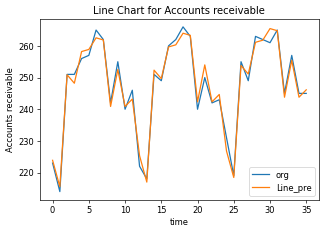

In [43]:
#轉換Quarter to Dummy variables
Quarter_dummy = pd.get_dummies(df['Month'], prefix = 'Month')
df_d = pd.concat([df, Quarter_dummy], axis = 1)
df_d.head()
y_data_df_d = df_d['Billions_of_miles']
X_data_ar_df_d = np.array([df_d['t'], df_d['Month_1'], df_d['Month_2'], df_d['Month_3'], df_d['Month_4']  , df_d['Month_5'], df_d['Month_6'], df_d['Month_7'], df_d['Month_8'] , df_d['Month_9'], df_d['Month_10'], df_d['Month_11']])
X_data_ar_df_d_T = X_data_ar_df_d.T
X_data_df_d = pd.DataFrame(X_data_ar_df_d_T, columns = ['t', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11'])
X_data_df_d = sm.add_constant(X_data_df_d)

#regression
olsmod_df_d_DM = sm.OLS(y_data_df_d, X_data_df_d)
result_reg_df_d_DM = olsmod_df_d_DM.fit()
print(result_reg_df_d_DM.summary())
df_d_DM_st, df_d_DM_data, df_d_DM_ss2 = sso.summary_table(result_reg_df_d_DM, alpha=0.05)

#regression results
df_d_DM_y_pre = df_d_DM_data[:, 2]
df_d_DM_SD = df_d_DM_data[:, 10]
des_pre_df_d_DM = df_d_DM_y_pre
print(des_pre_df_d_DM)
plt.plot(df_d['t'], df_d['Billions_of_miles'])
plt.plot(df_d['t'], des_pre_df_d_DM)
plt.legend(labels=['org', 'Line_pre'])
plt.xlabel('time')
plt.ylabel('Accounts receivable')
plt.title('Line Chart for Accounts receivable')
plt.show()

### Requirements check. 

In [44]:
data = df_d_DM_data
y_pre = data[:, 2]
SD = data[:, 10]

#### Normality
H0 : Normal distributed  
H1 : Not normal distributed 

In [45]:
stat, p = stats.shapiro(SD)
print('Shapiro Test: Statistics=%f, p=%f' % (stat, p))

Shapiro Test: Statistics=0.987975, p=0.957633


Since p-value > alpha = 0.05, we can not reject H0 at significance level at alpha = 0.05.  
There is no evidence to show that it is not normally distributed.  
#### Homoscedasticity
H0 : Homoscedasticity  
H1 : Not Homoscedasticity

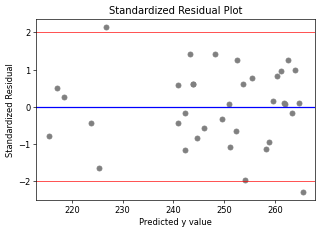

In [46]:
plt.plot(y_pre, SD, 'o', color = 'gray')
plt.axhline(y=2, color = 'red', lw = 0.8)
plt.axhline(y=0, color = 'blue')
plt.axhline(y=-2, color = 'red', lw = 0.8)
plt.title('Standardized Residual Plot')
plt.xlabel('Predicted y value')
plt.ylabel('Standardized Residual')
plt.show()

We do not reject H0. We can assume the variation is constant and the mean is around 0.
#### Independence
H0 : Independence  
H1 : Not independence  

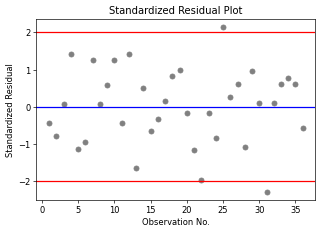

runs =  19
n1 =  18
n2 =  18
runs_exp =  19.0
stan_dev =  2.9568322818274866
z =  0.0
pval_z =  1.0
p_value for Z-statistic=  1.0


In [47]:
Id = data[:, 0]
plt.plot(Id, SD, 'o', color = 'gray')
plt.axhline(y=0, color = 'blue')
plt.axhline(y=2, color = 'red')
plt.axhline(y=-2, color = 'red')
plt.title('Standardized Residual Plot')
plt.xlabel('Observation No.')
plt.ylabel('Standardized Residual')
plt.show()

SD_median = statistics.median(SD)
Z_pval = runsTest(SD, SD_median) 
print('p_value for Z-statistic= ', Z_pval)

Since n1<=20 and n2<=20, we check with run table.  
lower bound = 4 < runs = 7 < upper bound = 14  
Thus, there is no evidence to infer the sample is not random selected.  
#### According to the results above, all requirements are satisfied  
#### Autocorreltaion  
H0: The data are not first-order correlated  
H1: The data are first-order correlated  

In [48]:
d = Durbin_Watson_test(SD)
print(d)

x_square_sum =  36.05486254803435
size =  36
x_d =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
x_d =  [ 0.         -0.34063343  0.85158358  1.36253373 -2.55475075  0.17031672
  2.21411732 -1.19221702  0.51095015  0.68126687 -1.70316717  1.87348388
 -3.07548702  2.14380988 -1.15435916  0.3298169   0.49472536  0.65963381
  0.16490845 -1.15435916 -0.98945071 -0.82454226  1.81399297 -0.65963381
  2.97479081 -1.87348388  0.34063343 -1.70316717  2.0438006  -0.85158358
 -2.38443404  2.38443404  0.51095015  0.17031672 -0.17031672 -1.19221702]
d =  2.191746137265235
2.191746137265235


size = 16, k = 2(includes intercept), dL = 0.98013, dU = 1.23538  
Since dU < d= 1.7757423389509335 < 4-dU, we can not reject H0.  
Thus, there is not enough evidence to infer that first order auto-correlation exist.  
We dont need to apply Autoregression model.

[228.25       219.91666667 255.25       252.58333333 262.58333333
 263.25       266.91666667 266.25       245.25       256.91666667
 245.25       247.58333333]


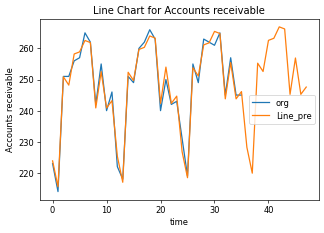

In [53]:
New_t_2 = np.array([[36, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [37, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [38, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
                    [39, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                    [40, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                    [41, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                    [42, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                    [43, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                    [44, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    [46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                    [47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Total_t_2 = np.append(df_d['t'], New_t_2[:,0])
New_t_2 = sm.add_constant(New_t_2)
df_d_DM_pre_New_t = result_reg_df_d_DM.predict(New_t_2)
print(df_d_DM_pre_New_t)
New_Nan = np.zeros(New_t_2.shape[0])
New_Nan[:] = np.nan

df_d_DM_New_orig = np.append(df_d['Billions_of_miles'], New_Nan)
df_d_DM_New_pre = np.append(des_pre_df_d_DM, df_d_DM_pre_New_t)
plt.plot(Total_t_2, df_d_DM_New_orig)
plt.plot(Total_t_2, df_d_DM_New_pre)
plt.legend(labels=['org', 'Line_pre'])
plt.xlabel('time')
plt.ylabel('Accounts receivable')
plt.title('Line Chart for Accounts receivable')
plt.show()



# Comparison

In [51]:
print('Error Metrics for Seasonal Index by Moving Average')
MA_Err_M = ErrMetrix(df['Billions_of_miles'], Sea_pre_df_MA)
print('\n')
print('Error Metrics for Seasonal Index by LR')
LR_Err_M = ErrMetrix(df['Billions_of_miles'], Sea_pre_df_LR)
print('\n')
print('Error Metrics for LR Dummy')
DM_Err_M = ErrMetrix(df['Billions_of_miles'], des_pre_df_d_DM)

Error Metrics for Seasonal Index by Moving Average
MAD =  1.674725
MSE =  4.984779
RMSE =  2.232662
MAPE =  0.679629 %


Error Metrics for Seasonal Index by LR
MAD =  1.622203
MSE =  4.229626
RMSE =  2.056605
MAPE =  0.657645 %


Error Metrics for LR Dummy
MAD =  1.615741
MSE =  3.915509
RMSE =  1.978765
MAPE =  0.655271 %


In [52]:
ErrM_id = ['MAD', 'MSE', 'RMSE', 'MAPE']
ErrM_a = np.array([ErrM_id, MA_Err_M, LR_Err_M, DM_Err_M])
ErrM_df = pd.DataFrame(ErrM_a.T, columns = ['ErrM', 'SIMA', 'SILR', 'Dummy'])
print('dataset:')
display(ErrM_df)

dataset:


,ErrM,SIMA,SILR,Dummy
0,MAD,1.674725,1.622203,1.615741
1,MSE,4.984779,4.229626,3.915509
2,RMSE,2.232662,2.056605,1.978765
3,MAPE,0.679629,0.657645,0.655271


#### According to the table above, we can see that SILR performs the best no matter which measurement method we use.